In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pint
ureg = pint.UnitRegistry()

from plotting import plot_unit_sphere
from marsaglia import UniformBeam, GaussianBeam

# The goal
I'm a developer of the [TOPAS](http://topasmc.org) Monte Carlo simulation tool for radiotherapy research. To improve our beam source model, I wanted a method to randomly generate uniformly distributed directions that are constrained to a certain region of the unit sphere, centered upon the z-axis (the beam direction). Generated particles are assigned these random directions before they are transported through the simulated geometry, in order to account for beam divergence. In fact, the final goal was a normal distribution of directions, but I knew I needed a uniform distribution to verify that the method worked.

In our previous situation, we had two methods for generating random directions:

1. **isotropic source**: 
    to generate points uniformly across the entire unit sphere, we sample $u \in [-1, 1]$ and $\phi \in [0, 2\pi)$ from uniform distributions. We then apply the following coordinate transformation (note that $u = \cos\theta$)
    $$\begin{align}
    x &= \sqrt{1-u^2} \cos\phi \\
    y &= \sqrt{1-u^2} \sin\phi \\
    z &= u
    \end{align}$$
    .
2. **beam source**:
    to generate points normally distributed around the z-axis upon the unit sphere, we sample $u_x = \mathcal{N}(0, \cos\theta_x)$ and $u_y = \mathcal{N}(0, \cos\theta_y)$ from normal distributions. Note that $\theta_x$ and $\theta_y$ are user parameters that determine the beam divergence in each plane. We then apply the following coordinate transformation
    $$\begin{align}
    x &= \cos^{-1} u_x \\
    y &= \cos^{-1} u_y \\
    z &= \sqrt{1 - u_x^2 - u_y^2}
    \end{align}$$

The problems with this second method are that it cannot generate uniformly distributed directions and that it is only valid in the small-angle approximation, $\theta_x \ll 1$ and $\theta_y \ll 1$. I wanted a method that could resolve this problems, but our isotropic method did not naturally extend to beams with a direction.

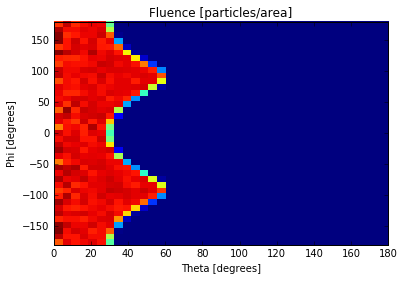

In [2]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, ToggleButtons
from IPython.display import display

fig = plt.figure()
plt.xlabel('Theta [degrees]')
plt.ylabel('Phi [degrees]')
plt.title('Fluence [particles/area]')

theta_edges = np.linspace(   0, 180, 40)
phi_edges   = np.linspace(-180, 180, 40)

cos_edges = np.cos(np.deg2rad(theta_edges))
bin_wgts = 1./(cos_edges[:-1] - cos_edges[1:])

def plot_hist(theta_x, theta_y, source_type):
    source = source_type(theta_x*ureg.degree, theta_y*ureg.degree)
    x,y,z = source.generate(1000000)
    
    theta = np.rad2deg(np.arccos(z))
    phi = np.rad2deg(np.arctan2(y, x))
    
    wgt = bin_wgts[np.digitize(theta, theta_edges)-1]   # account for how solid area depends on theta
    
    plt.hist2d(theta, phi, bins=[theta_edges,phi_edges], weights=wgt, normed=True)

    
w_theta_x = FloatSlider(min=1e-3, max=180, value=30, description='$\\theta_x$', continuous_update=False)
w_theta_y = FloatSlider(min=1e-3, max=180, value=60, description='$\\theta_y$', continuous_update=False)
w_source = ToggleButtons(options={'Uniform': UniformBeam, 'Gaussian': GaussianBeam}, value=UniformBeam, description='Beam:')
    
_ = interact(plot_hist, theta_x=w_theta_x, theta_y=w_theta_y, source_type=w_source)

# Marsaglia transform
Several different methods of uniformly sampling points on the unit sphere are described in this [Wolfram MathWorld page](http://mathworld.wolfram.com/SpherePointPicking.html). For my purposes, the most useful was a method derived by Marsaglia (1972).

First, points are generated within a unit circle by uniformly sampling $x_1 \in [-1, 1]$ and $x_2 \in [-1, 1]$ and rejecting points with $x_1^2 + x_2^2 \ge 1$. Then the radial distance of each point is used to determine the polar angle of the direction upon the unit sphere. This is achieved with the following coordinate transformation

$$\begin{align}
x &= 2 x_1 \sqrt{1 - x_1^2 - x_2^2} \\
y &= 2 x_2 \sqrt{1 - x_1^2 - x_2^2} \\
z &= 1 - 2(x_1^2 + x_2^2)
\end{align}$$


Here is a helpful visualization of the Marsaglia transformation, courtesy of this [StackOverflow answer](http://math.stackexchange.com/a/838336). The red circle originally has a radius of 1 and is transformed to the south pole. The purple circle originally has a radius of $\sqrt{0.5} \approx 0.71$ and is transformed to the equator. A uniform distribution on the unit disc is transformed into a uniform distribution on the unit sphere.
![Animation of Marsaglia transformation](http://i.stack.imgur.com/qxPG3.gif)

Marsaglia, G. "Choosing a Point from the Surface of a Sphere." *Ann. Math. Stat.* **43**, 645-646, 1972.

# A uniform beam direction generator

In [3]:
source = UniformBeam(60*ureg.degree, 120*ureg.degree)
x,y,z = source.generate(1000)

print('Efficiency = {:.1%}'.format(source.efficiency()))
print('Predicted efficiency for UniformBeamSource is {:.1%}'.format(np.pi/4))

Efficiency = 79.1%
Predicted efficiency for UniformBeamSource is 78.5%


<IPython.core.display.Javascript object>


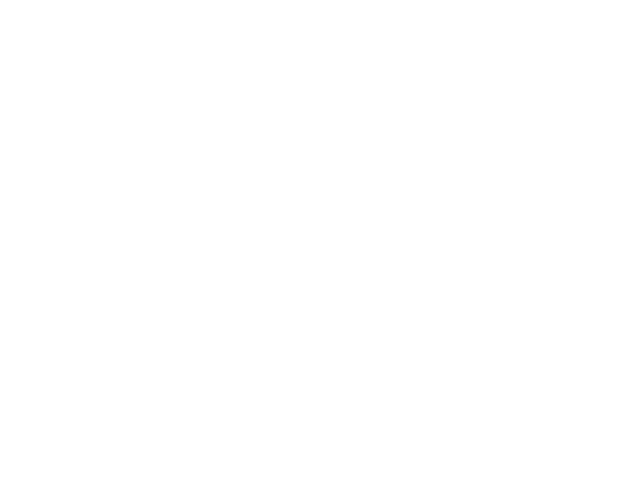

In [4]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_unit_sphere(ax)

ax.scatter(x,y,z, c='r', s=20, edgecolors='face')

# A bonus direction generator: Gaussian
It is simple to extend the previous direction generator to sample a Gaussian distribution instead of a uniform distribution.

<IPython.core.display.Javascript object>


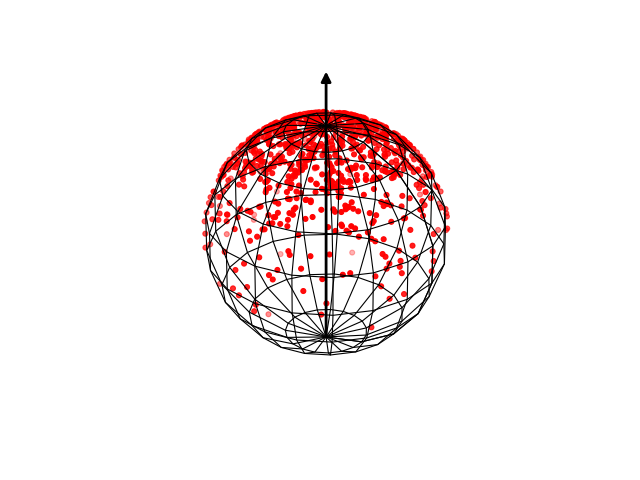

In [5]:
%matplotlib notebook

source = GaussianBeam(30*ureg.degree, 30*ureg.degree)
x,y,z = source.generate(1000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_unit_sphere(ax)

ax.scatter(x,y,z, c='r', s=20, edgecolors='face')